In [1]:
import os
import argparse
import time
import seaborn
from contextlib import contextmanager
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import sys
sys.path.append("../")
from oodeel.methods import MLS, Energy, Entropy, DKNN, Gram, Mahalanobis, ODIN, VIM
from methods import   K_Means_Mahalanobis, PCA_MAHALANOBIS, NMF_MAHALANOBIS, PCA_unique_class_KNN, PCA_Unique_Class_Mahalanobis, NMF_Unique_Classes_KNN, NMF_Unique_Class_Mahalanobis, NMF_NORM, CRAFT_PER_CLASS_NMF, CRAFT_PER_CLASS_NMF_V2
from methods_v2 import K_Means, NMF_KNN, PCA_KNN, NMF_CONCEPTS, CRAFT_CONCEPTS, PCA_NORM
from data_preprocessing import get_train_dataset_cifar10, get_test_dataset_cifar10, get_train_dataset_cifar100, get_test_dataset_cifar100, get_test_dataset_places365, get_test_dataset_svhn, get_test_dataset_texture, get_test_dataset_Tiny, get_test_dataset_NINCO, get_test_dataset_OpenImage_O, get_train_dataset_inaturalist, get_test_dataset_SSB_hard
from models import load_pretrained_weights_32
from oodeel.eval.metrics import bench_metrics
from oodeel.types import List
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features, plot_3D_features
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.datasets import cifar10, mnist
import scipy.io




# load the model with pretrained weights
model = load_pretrained_weights_32()

# 1a- load in-distribution dataset: CIFAR-10
ds_fit = get_train_dataset_cifar10()
ds_in = get_test_dataset_cifar10()
ds_out = get_test_dataset_svhn()
# 1b- load out-of-distribution datasets

cifar_10 = get_test_dataset_cifar10().dataset # (x, y) where x is the image and y is the label
# get the names of the classes and their corresponding labels
classes_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# # Function to visualize the original images where every row is a class and every column is a sample
# def visualize_images(dataset, num_samples=5):
#     fig, axs = plt.subplots(10, num_samples, figsize=(num_samples * 2, 20))
#     for i in range(10):
#         # Add class name to every row
#         class_i = [image for image, label in dataset if label == i]
#         axs[i, 0].set_ylabel(f'Class {classes_names[i]}', fontsize=12, rotation=0, labelpad=50)
#         for j in range(num_samples):
#             axs[i, j].imshow(class_i[j].permute(1, 2, 0) * 0.5 + 0.5)
#             axs[i, j].axis('off')
        
#     plt.tight_layout()
#     plt.show()

# visualize_images(cifar_10, num_samples=5)





2024-06-13 14:20:40.005045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 14:20:41.199218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


checkpoint_path :  ../../models/CIFAR-10/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !
the length of the CIFAR-10 Training dataset :  50000
the length of the CIFAR-10 Test dataset :  10000
the length of the SVHN Test dataset :  26032
the length of the CIFAR-10 Test dataset :  10000


extracting features .................................


Performing K-means clustering...
K-means clustering Done...
Done fitting ......
Done t-SNE ......


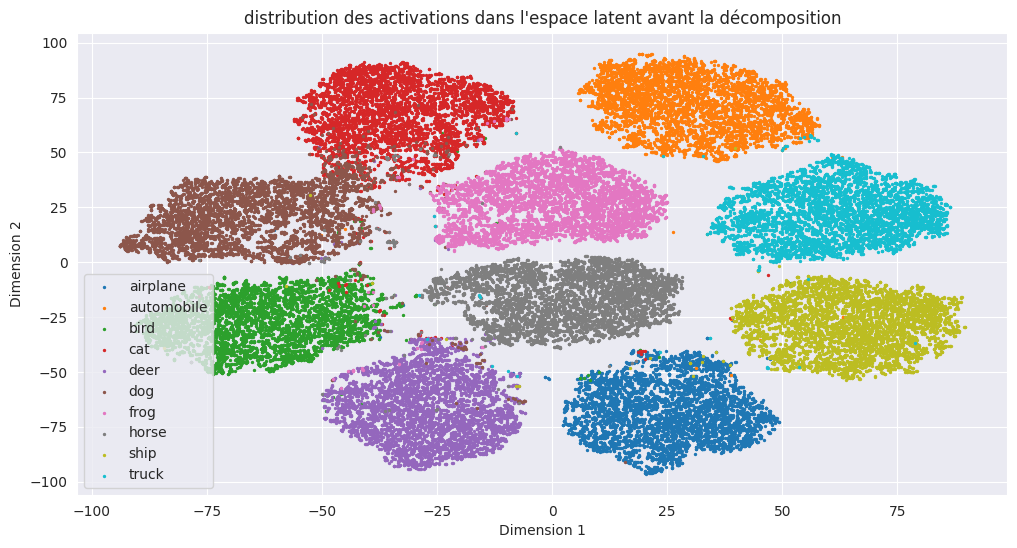

In [5]:
# instantiate the method
Kmeans = K_Means(n_centroids=10)
# fit the method with the dataset
Kmeans.fit(model.to("cuda:1"), fit_dataset=ds_fit, feature_layers_id=[-2])
print("Done fitting ......")
# Réduire les données à 2 dimensions avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_train_kmeans_tsne = tsne.fit_transform(Kmeans.A_train)
print("Done t-SNE ......")
labels = Kmeans.Labels_train
classes_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


plt.figure(figsize=(12, 6))
for i in range(10):
    plt.scatter(x_train_kmeans_tsne[labels == i, 0], x_train_kmeans_tsne[labels == i, 1], label=classes_names[i], s=2)
plt.legend()
plt.title("distribution des activations dans l'espace latent avant la décomposition")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Done t-SNE ......


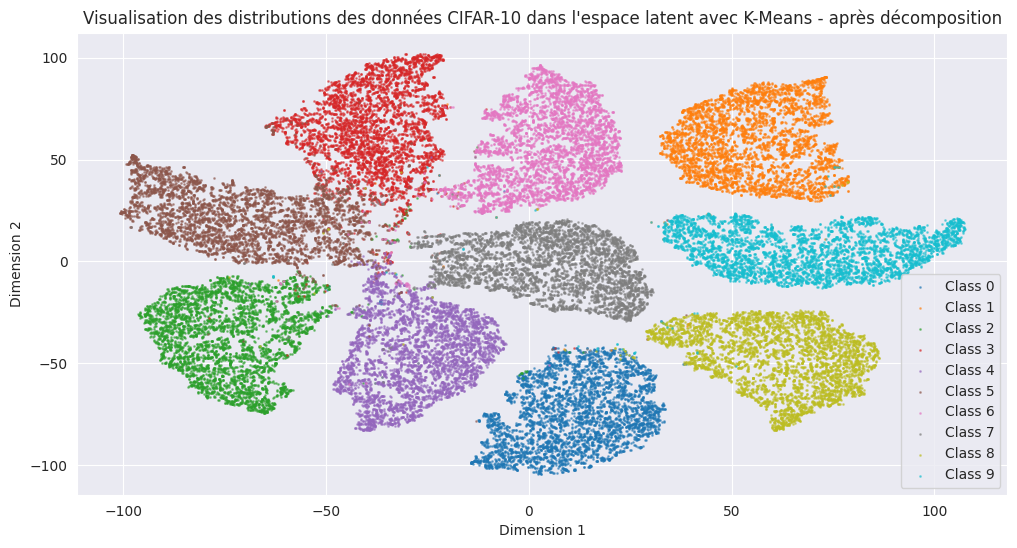

In [3]:
# # Réduire les données à 2 dimensions avec t-SNE pour les données après décomposition
tsne_2 = TSNE(n_components=2, random_state=42)
x_train_kmeans_tsne_2 = tsne_2.fit_transform(Kmeans.U)
print("Done t-SNE ......")
labels_2 = Kmeans.Labels_train

plt.figure(figsize=(12, 6))

# Visualiser CIFAR-10 with every class has its own color
for i in range(10):
    plt.scatter(x_train_kmeans_tsne_2[labels == i, 0], x_train_kmeans_tsne_2[labels_2 == i, 1], label=f'Class {i}', alpha=0.5, s=1)
plt.legend()
plt.title("Visualisation des distributions des données CIFAR-10 dans l'espace latent avec K-Means - après décomposition")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

extracting features .....................


Applying PCA Algorithm .....................
fitting KNN Algorithm .....................
Done Fitting .....................
Done fitting ......
Done t-SNE ......


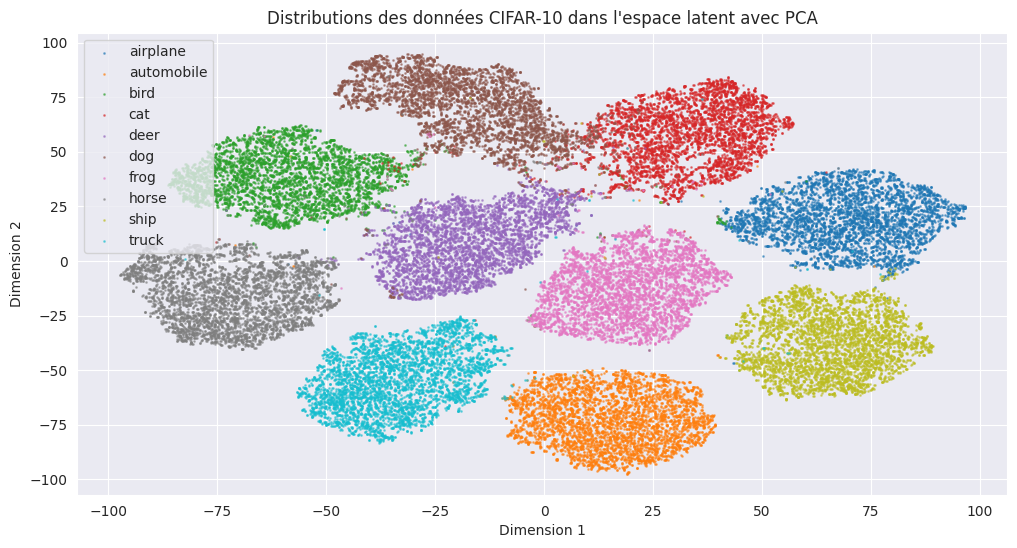

In [2]:
# instantiate the method
pca = PCA_KNN(n_components=16)
# fit the method with the dataset
pca.fit(model.to("cuda:1"), fit_dataset=ds_fit, feature_layers_id=[-2])
print("Done fitting ......")
# Réduire les données à 2 dimensions avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_train_kmeans_tsne = tsne.fit_transform(pca.A_train)
print("Done t-SNE ......")
labels = pca.Labels_train

plt.figure(figsize=(12, 6))

# Visualiser CIFAR-10 with every class has its own color
for i in range(10):
    plt.scatter(x_train_kmeans_tsne[labels == i, 0], x_train_kmeans_tsne[labels == i, 1], label=classes_names[i], alpha=0.5, s=1)
plt.legend()
plt.title("Distributions des données CIFAR-10 dans l'espace latent avec PCA")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Done t-SNE ......


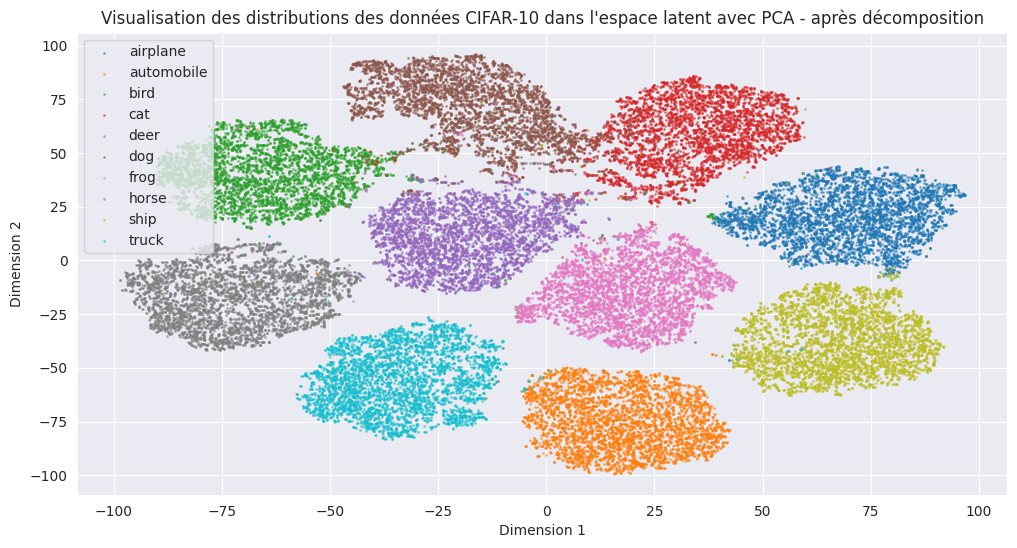

In [3]:
# # Réduire les données à 2 dimensions avec t-SNE pour les données après décomposition
tsne_2 = TSNE(n_components=2, random_state=42)
x_train_pca_tsne_2 = tsne_2.fit_transform(pca.U)
print("Done t-SNE ......")
labels_2 = pca.Labels_train

plt.figure(figsize=(12, 6))

# Visualiser CIFAR-10 with every class has its own color
for i in range(10):
    plt.scatter(x_train_pca_tsne_2[labels_2 == i, 0], x_train_pca_tsne_2[labels_2 == i, 1], label=classes_names[i], alpha=0.5, s=1)
plt.legend()
plt.title("Visualisation des distributions des données CIFAR-10 dans l'espace latent avec PCA - après décomposition")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

extracting features .................................
applying NMF .................................
fitting the KNN algorithm .................................
Done fitting ...........................
Done fitting ......
Done t-SNE ......


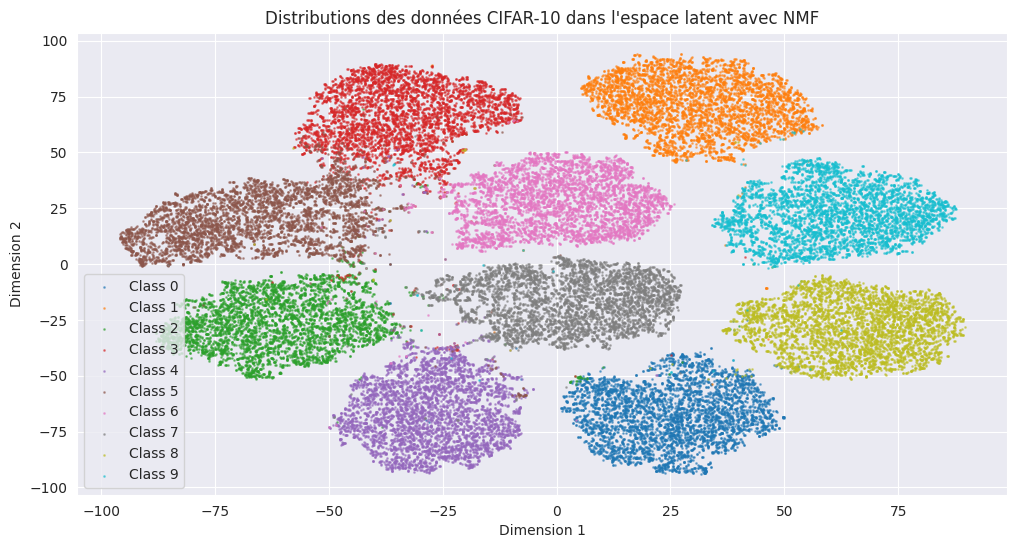

In [2]:
# instantiate the method
nmf = NMF_KNN(n_components=16)
# fit the method with the dataset
nmf.fit(model.to("cuda:1"), fit_dataset=ds_fit, feature_layers_id=[-2])
print("Done fitting ......")
# Réduire les données à 2 dimensions avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_train_nmf_tsne = tsne.fit_transform(nmf.A_train)
print("Done t-SNE ......")
labels = nmf.Labels_train

plt.figure(figsize=(12, 6))

# Visualiser CIFAR-10 with every class has its own color
for i in range(10):
    plt.scatter(x_train_nmf_tsne[labels == i, 0], x_train_nmf_tsne[labels == i, 1], label=f'Class {i}', alpha=0.5, s=1)
plt.legend()
plt.title("Distributions des données CIFAR-10 dans l'espace latent avec NMF")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Done t-SNE ......


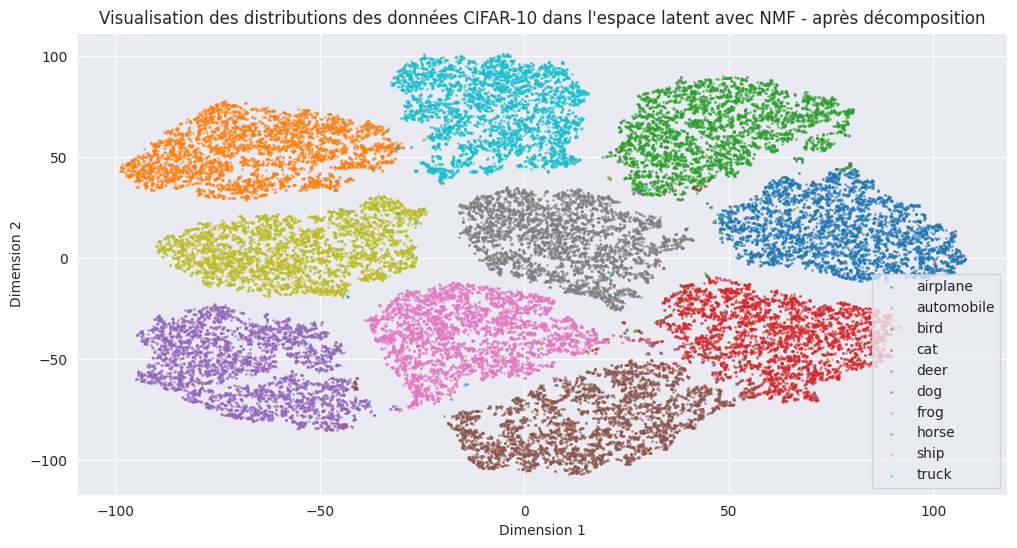

In [3]:
# # Réduire les données à 2 dimensions avec t-SNE pour les données après décomposition
tsne_2 = TSNE(n_components=2, random_state=42)
x_train_nmf_tsne_2 = tsne_2.fit_transform(nmf.U)
print("Done t-SNE ......")
labels_2 = nmf.Labels_train

plt.figure(figsize=(12, 6))

# Visualiser CIFAR-10 with every class has its own color
for i in range(10):
    plt.scatter(x_train_nmf_tsne_2[labels_2 == i, 0], x_train_nmf_tsne_2[labels_2 == i, 1], label=classes_names[i], alpha=0.5, s=1)
plt.legend()
plt.title("Visualisation des distributions des données CIFAR-10 dans l'espace latent avec NMF - après décomposition")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

checkpoint_path :  ../../models/CIFAR-10/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !
extracting features .................................
length of dataset :  50000
getting correctly classified samples .................................
accuracy of the model :  97.44800000000001


calculating NMF ...................................
calculating top important concepts ...................................
calculating the concept :  1000
calculating the concept :  10000
calculating the concept :  30000
calculating the concept :  40000
importances before :  [0.02223522 0.01637317 0.0706722  0.01681491 0.02478804 0.02907865
 0.08258957 0.06305795 0.04590676 0.06542919 0.05884099 0.04098985
 0.06667554 0.0089959  0.04794082 0.05079751]
most important concepts :  [ 6  2 12  9  7 10 15 14  8 11]
importances after :  [0.02223522 0.01637317 0.0706722  0.01681491 0.02478804 0.02907865
 0.08258957 0.06305795 0.04590676 0.0654291

/home/bilal.el-manja/project_deel/OOD_Detection_Benchmarking/src/visualizations/../methods_v2/craft_concepts.py:161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[f"Concept {c}" for c in self.most_important_concepts[:self.n_important_concepts]],


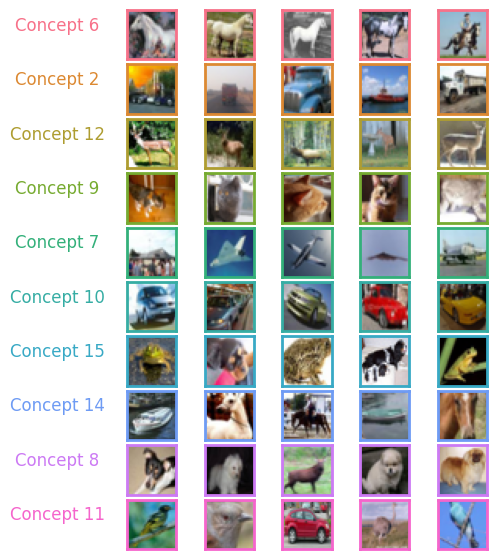

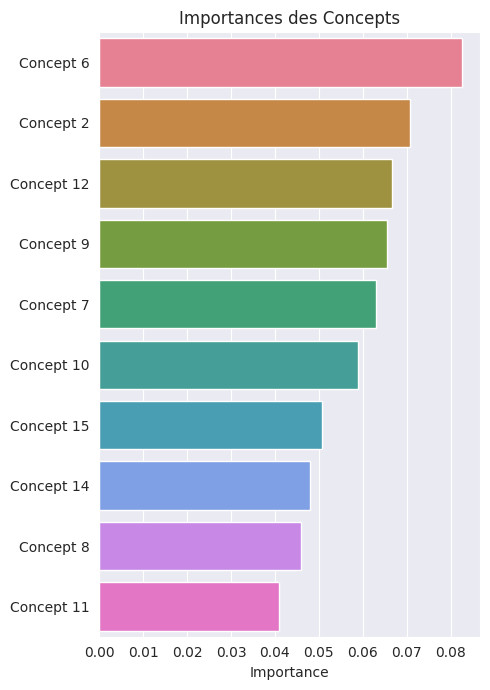

In [2]:
# instantiate the method
craft = CRAFT_CONCEPTS(n_components=16, n_important_concepts=10, percentage_images_concept=0.1, model=load_pretrained_weights_32())
# fit the method with the dataset
craft.fit(model.to("cuda:1"), fit_dataset=ds_fit, feature_layers_id=[-2])
print("Done fitting ......")
craft.visualize_concepts_images()
# # Réduire les données à 2 dimensions avec t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# x_train_nmf_tsne = tsne.fit_transform(craft.A_train)
# print("Done t-SNE ......")
# labels = craft.Labels_train

# plt.figure(figsize=(12, 6))

# # Visualiser CIFAR-10 with every class has its own color
# for i in range(10):
#     plt.scatter(x_train_nmf_tsne[labels == i, 0], x_train_nmf_tsne[labels == i, 1], label=f'Class {i}', alpha=0.5, s=1)
# plt.legend()
# plt.title("Distributions des données CIFAR-10 dans l'espace latent avec NMF")
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.show()

AttributeError: 'int' object has no attribute 'get_x'

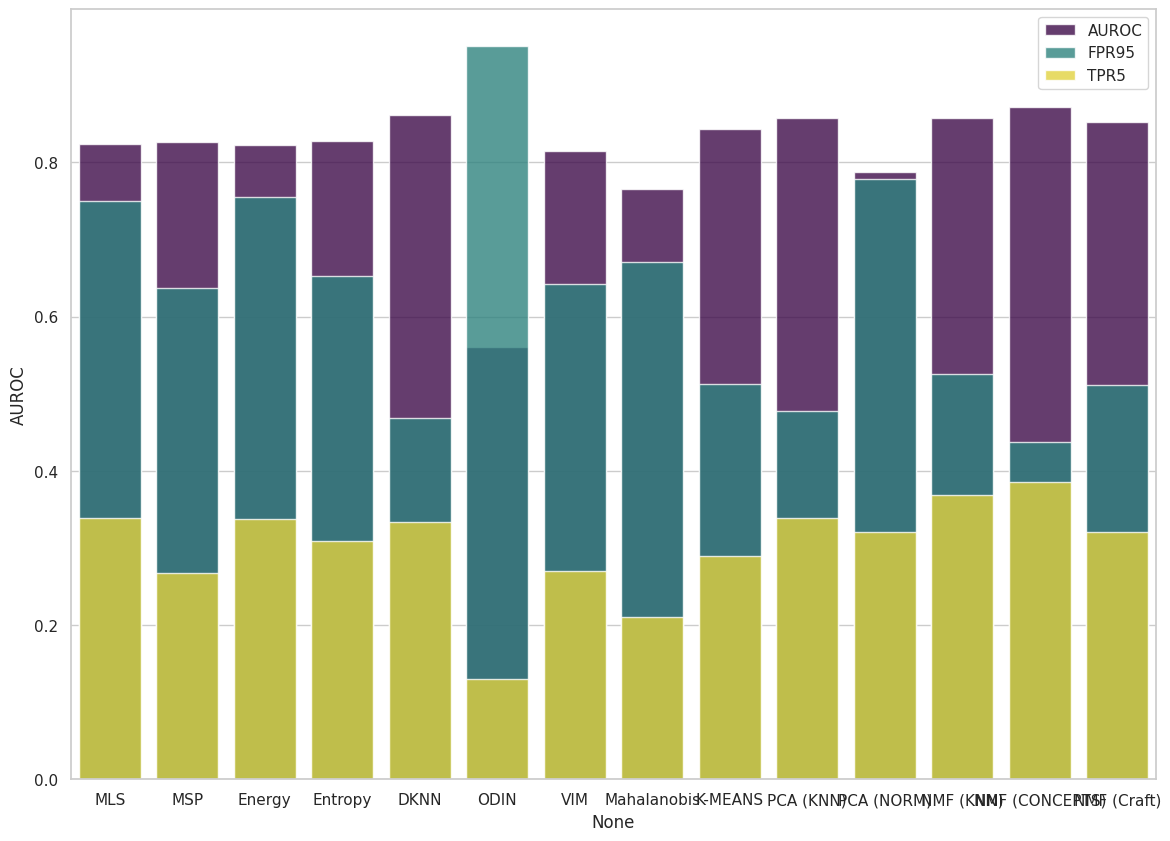

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the data
methods = ["MLS", "MSP", "Energy", "Entropy", "DKNN", "ODIN", "VIM", "Mahalanobis", "K-MEANS", "PCA (KNN)", "PCA (NORM)", "NMF (KNN)", "NMF (CONCEPTS)", "NMF (Craft)"]
values = {
    "AUROC": [0.824, 0.826, 0.823, 0.828, 0.861, 0.561, 0.815, 0.765, 0.843, 0.858, 0.787, 0.857, 0.872, 0.852],
    "FPR95": [0.750, 0.637, 0.755, 0.652, 0.468, 0.951, 0.642, 0.671, 0.513, 0.478, 0.778, 0.526, 0.438, 0.511],
    "TPR5": [0.339, 0.267, 0.338, 0.309, 0.333, 0.130, 0.270, 0.210, 0.289, 0.339, 0.320, 0.368, 0.385, 0.321]
}
df = pd.DataFrame(values, index=methods)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 10))

# Custom color gradient
colors = plt.cm.viridis(np.linspace(0, 1, 3))  # Using viridis gradient

# Plot each metric with a different color
for i, metric in enumerate(df.columns):
    sns.barplot(x=df.index, y=df[metric], ax=ax, color=colors[i], label=metric, alpha=0.8)

# Custom styling
sns.set_style("whitegrid")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metrics")

# Annotations
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, f'{i.get_height():.2f}', ha='center', va='bottom', color='black', fontweight='bold')

# Title and labels
plt.title('Comparison of OOD Detection Methods Across Different Metrics', fontsize=16)
plt.xlabel('Method', fontsize=12)
plt.ylabel('Values', fontsize=12)

plt.tight_layout()
plt.show()


/tmp/ipykernel_672043/296770756.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Method', y='Score_Time_ms_per_img', data=df, palette=palette)


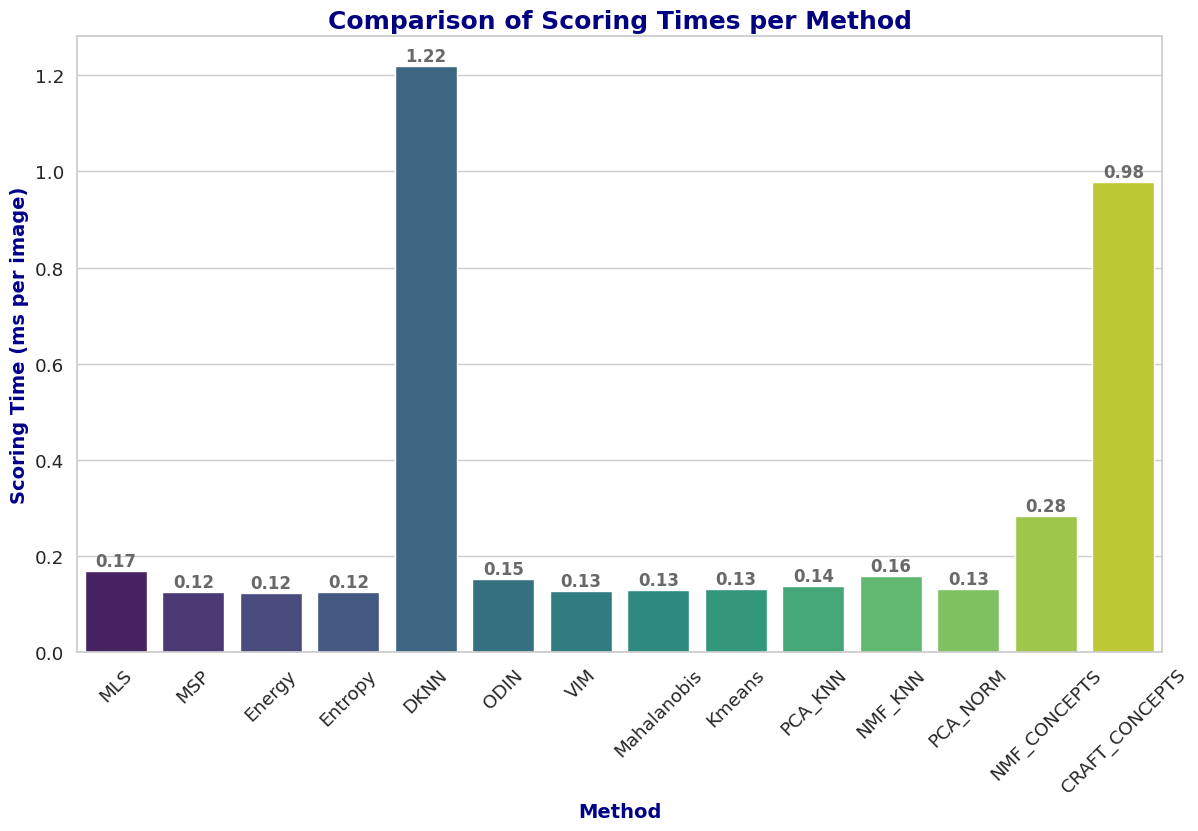

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Données fictives des temps de scoring en millisecondes par image
data = {
    "Method": ["MLS", "MSP", "Energy", "Entropy", "DKNN", "ODIN", "VIM", "Mahalanobis", "Kmeans", "PCA_KNN", "NMF_KNN", "PCA_NORM", "NMF_CONCEPTS", "CRAFT_CONCEPTS"],
    "Score_Time_ms_per_img": [0.170, 0.125, 0.124, 0.125, 1.220, 0.153, 0.127, 0.130, 0.132, 0.139, 0.159, 0.132, 0.283, 0.978]
}

# Création d'un DataFrame
df = pd.DataFrame(data)

# Configuration du style de Seaborn
sns.set(style="whitegrid", palette="deep", font_scale=1.2, rc={"figure.figsize": (14, 5)})

# Choix d'une palette de couleurs
palette = sns.color_palette("viridis", n_colors=len(data["Method"]))

# Création du graphique
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Method', y='Score_Time_ms_per_img', data=df, palette=palette)

# Titre et labels
bar_plot.set_title('Comparison of Scoring Times per Method', fontsize=18, fontweight='bold', color='navy')
bar_plot.set_xlabel('Method', fontsize=14, fontweight='bold', color='darkblue')
bar_plot.set_ylabel('Scoring Time (ms per image)', fontsize=14, fontweight='bold', color='darkblue')

# Rotation des labels sur l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Ajouter des annotations directement sur les barres
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.text(p.get_x() + p.get_width() / 2., height + 0.01, f'{height:.2f}', ha="center", fontsize=12, color='dimgrey', fontweight='bold')

# Afficher le graphique
plt.show()


/tmp/ipykernel_83857/1012706085.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df.T, ci=None, palette='viridis')
/tmp/ipykernel_83857/1012706085.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12, fontweight='normal', fontname='sans-serif')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


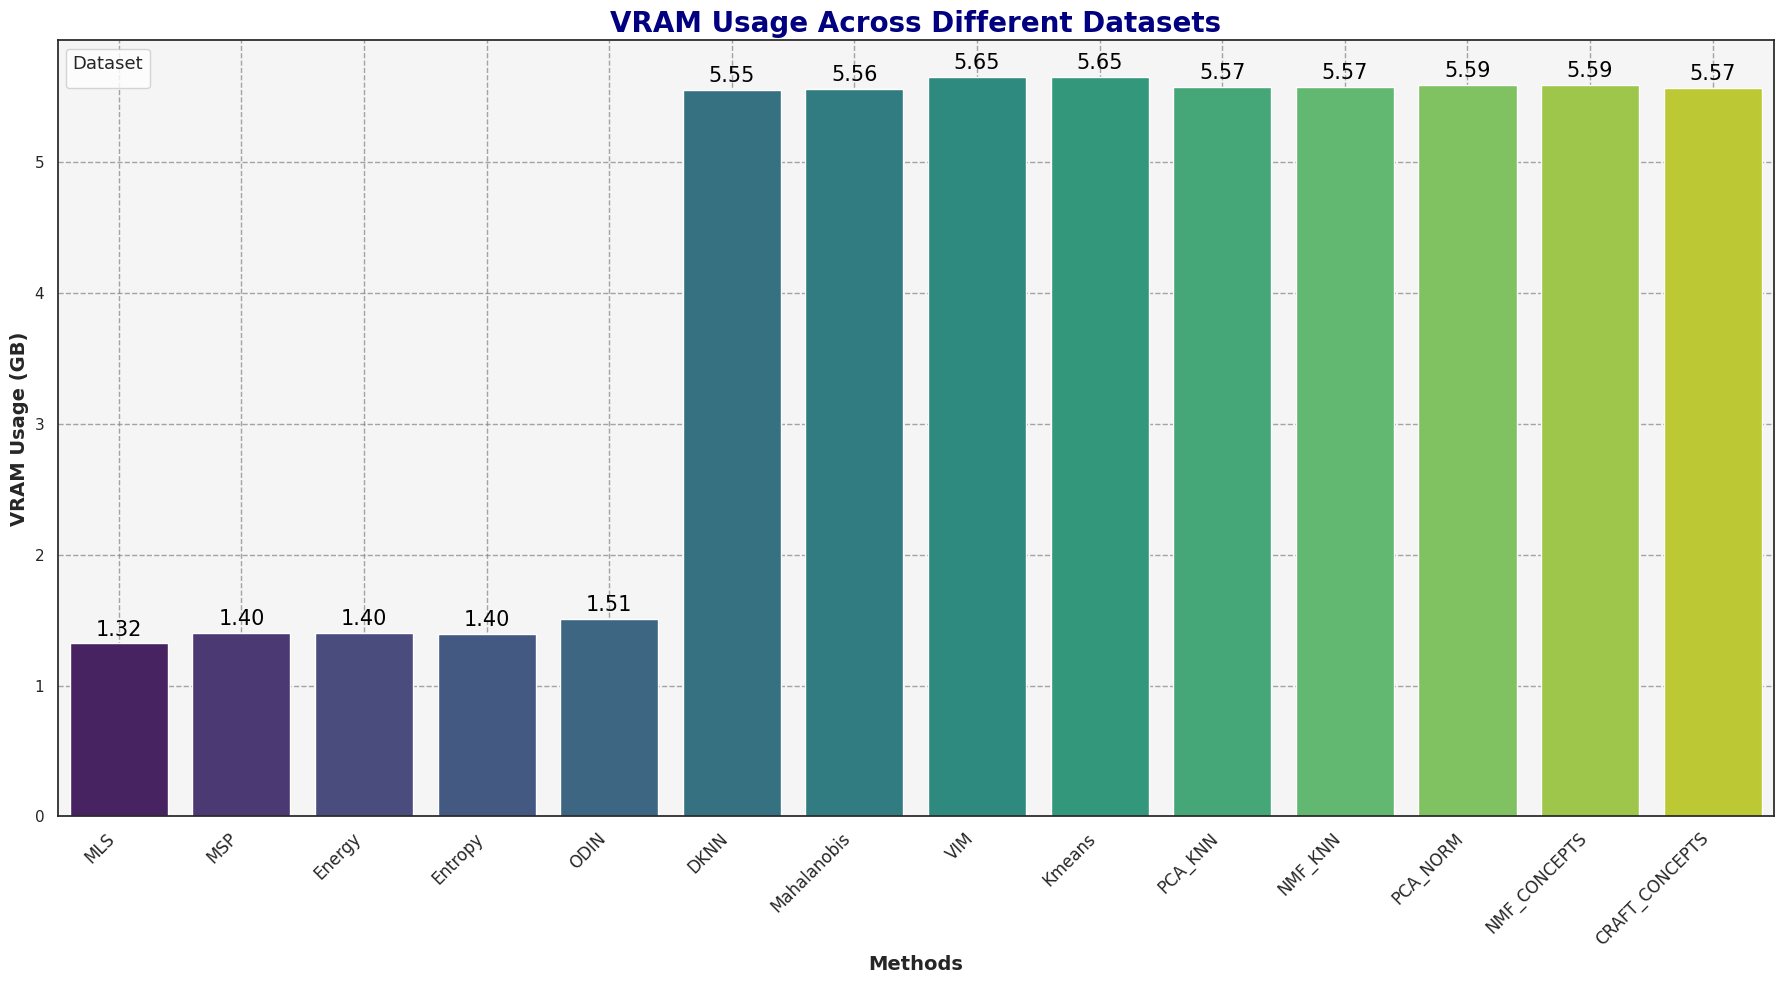

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data preparation
data = {
    "CIFAR-100": [1.322, 1.400, 1.400, 1.398, 1.510, 5.555, 5.562, 5.650, 5.650, 5.574, 5.574, 5.592, 5.592, 5.570],
    "Places365": [1.322, 1.400, 1.400, 1.398, 1.510, 5.555, 5.562, 5.650, 5.650, 5.574, 5.574, 5.592, 5.592, 5.570],
    "SVHN": [1.322, 1.400, 1.400, 1.398, 1.510, 5.555, 5.562, 5.650, 5.650, 5.574, 5.574, 5.592, 5.592, 5.570],
    "Texture": [1.322, 1.400, 1.400, 1.398, 1.510, 5.555, 5.562, 5.650, 5.650, 5.574, 5.574, 5.592, 5.592, 5.570],
    "Tiny": [1.322, 1.400, 1.400, 1.398, 1.510, 5.555, 5.562, 5.650, 5.650, 5.574, 5.574, 5.592, 5.592, 5.570]
}

methods = ["MLS", "MSP", "Energy", "Entropy", "ODIN", "DKNN", "Mahalanobis", "VIM", "Kmeans", "PCA_KNN", "NMF_KNN", "PCA_NORM", "NMF_CONCEPTS", "CRAFT_CONCEPTS"]

df = pd.DataFrame(data, index=methods)

# Setting up Seaborn
sns.set(style="white", palette="muted")
plt.figure(figsize=(18, 10))
ax = sns.barplot(data=df.T, ci=None, palette='viridis')

# Customize ticks and labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12, fontweight='normal', fontname='sans-serif')
plt.title('VRAM Usage Across Different Datasets', fontsize=20, fontweight='bold', color='navy', fontname='sans-serif')
plt.ylabel('VRAM Usage (GB)', fontsize=14, fontweight='bold', fontname='sans-serif')
plt.xlabel('Methods', fontsize=14, fontweight='bold', fontname='sans-serif')
plt.legend(title='Dataset', title_fontsize='13', fontsize='12', loc='upper left')

# Customizing the grid and background
ax.set_facecolor('whitesmoke') # change background color
plt.grid(True, linestyle='--', linewidth=1, alpha=0.7, color='gray')

# Adding data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=15, color='black', rotation=0, xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()

